In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml
%config Completer.use_jedi = False

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/OK/OK_habitual_sentencing/OK_prison_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
# test_sim.simulate_baseline(['prison'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1770: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 1200 results
transitions_data returned 361 results
total_population_data returned 0 results


initialization time:  130.06329822540283
simulation_time:  94.1556715965271
initialization time:  129.0890052318573
simulation_time:  88.40096783638


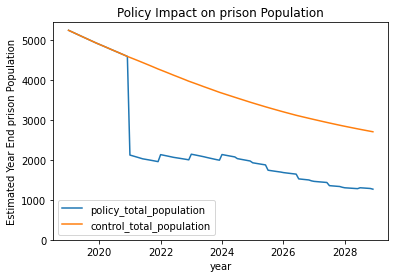

In [5]:
pd.set_option('display.max_rows', 500)

# Policy Option Methods
max_sentences = {f'max_sentence_{i}_yr': i * 12 * 0.49 for i in [1, 2, 3, 4, 5, 7, 8, 10, 15, 20]}

policy_transitions = test_sim.data_dict['transitions_data'][test_sim.data_dict['transitions_data'].compartment == 'prison'].copy()

for subgroup, sentence in max_sentences.items():
    policy_transitions.loc[(policy_transitions.crime_type == subgroup) & 
                           (policy_transitions.compartment_duration > sentence), 'compartment_duration'] = sentence



def remove_sentencing_enhancement(subgroup, retroactive=True):
    return partial(CompartmentTransitions.use_alternate_transitions_data, 
                   alternate_historical_transitions=policy_transitions[policy_transitions.crime_type == subgroup],
                   retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=remove_sentencing_enhancement(subgroup, True),
                spark_compartment='prison',
                sub_population={'crime_type': subgroup},
                apply_retroactive=True)
    for subgroup in max_sentences
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [6]:
fours = test_sim.data_dict['transitions_data'][test_sim.data_dict['transitions_data'].crime_type == 'max_sentence_4_yr']
fours = fours[fours.compartment == 'prison']
a = CompartmentTransitions(fours)
a.initialize([])
a.transition_dfs

{'before': outflow_to            release  remaining
 compartment_duration                    
 1                         0.0        1.0
 2                         0.0        1.0
 3                         0.0        1.0
 4                         0.0        1.0
 5                         0.0        1.0
 ...                       ...        ...
 146                       0.0        1.0
 147                       0.0        1.0
 148                       0.0        1.0
 149                       0.0        1.0
 150                       1.0        0.0
 
 [150 rows x 2 columns],
 'transitory': outflow_to            release  remaining
 compartment_duration                    
 1                         0.0        1.0
 2                         0.0        1.0
 3                         0.0        1.0
 4                         0.0        1.0
 5                         0.0        1.0
 ...                       ...        ...
 146                       0.0        1.0
 147                     

In [5]:
test_data = pd.DataFrame({
            'compartment_duration': [1, 2, 5],
            'total_population': [2, 4, 1],
            'outflow_to': ['jail', 'jail', 'jail'],
            'compartment': ['test_compartment'] * 3
        })
new_data = pd.DataFrame({
            'compartment_duration': [1, 2, 3],
            'total_population': [1, 2, 4],
            'outflow_to': ['jail', 'jail', 'jail'],
            'compartment': ['test_compartment'] * 3
        })
def policy():
    return partial(CompartmentTransitions.use_alternate_transitions_data, alternate_historical_transitions=new_data, retroactive=True)
t = CompartmentTransitions(test_data)
t.initialize([SparkPolicy(policy_fn=policy(),
                spark_compartment='prison',
                sub_population={'crime_type': 'x'},
                apply_retroactive=True)])


KeyError: 'policy'

In [6]:
simulation_tag = 'OK_habitual_sentencing'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [7]:
test_sim.output_data['life_years']

,prison_new_offense,release,prison_technical,probation
year,,,,
2019.000000,-0.001668,-0.286838,-0.002861,0.291455
2019.083333,-0.003330,-0.574282,-0.005717,0.583506
2019.166667,-0.004985,-0.862302,-0.008569,0.876123
2019.250000,-0.006636,-1.150866,-0.011418,1.169276
2019.333333,-0.008282,-1.439948,-0.014259,1.462937
...,...,...,...,...
2028.583333,-19.386651,-14198.899323,711.113025,13507.183865
2028.666667,-19.663148,-14484.164342,721.711282,13782.127220
2028.750000,-19.938472,-14771.427949,732.233568,14059.143959


In [6]:
test_sim.output_data['life_years']

,prison_new_offense,release,prison_technical,probation
year,,,,
2019.000000,-0.002094,-0.299183,-0.003625,0.304998
2019.083333,-0.004179,-0.599141,-0.007241,0.610753
2019.166667,-0.006255,-0.899844,-0.010847,0.917236
2019.250000,-0.008325,-1.201261,-0.014444,1.224417
2019.333333,-0.010387,-1.503358,-0.018029,1.532259
...,...,...,...,...
2028.583333,-13.124750,-17007.892523,842.607207,16178.421918
2028.666667,-12.814180,-17358.118949,855.795426,16515.149657
2028.750000,-12.491085,-17710.831560,868.914107,16854.420595


In [8]:
test_sim.pop_simulations['control'].sub_simulations['x'].simulation_compartments['prison_parole_revocations'].transition_tables.transition_dfs

{'before':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'transitory':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.0        1.0
 8      0.0        1.0
 9      0.0        1.0
 10     0.0        1.0
 11     0.0        1.0
 12     0.0        1.0
 13     0.0        1.0
 14     0.0        1.0
 15     0.0        1.0
 16     1.0        0.0,
 'after_retroactive':     parole  remaining
 1      0.0        1.0
 2      0.0        1.0
 3      0.0        1.0
 4      0.0        1.0
 5      0.0        1.0
 6      0.0        1.0
 7      0.

In [4]:
test_data = pd.DataFrame({
            'compartment_duration': [1, 2, 5],
            'total_population': [2, 4, 1],
            'outflow_to': ['jail', 'jail', 'jail'],
            'compartment': ['test_compartment'] * 3
        })
new_data = pd.DataFrame({
            'compartment_duration': [1, 2, 3],
            'total_population': [1, 2, 4],
            'outflow_to': ['jail', 'jail', 'jail'],
            'compartment': ['test_compartment'] * 3
        })
def policy():
    return partial(CompartmentTransitions.use_alternate_transitions_data, alternate_historical_transitions=new_data, retroactive=True)
t = CompartmentTransitions(test_data)
t.initialize([SparkPolicy(policy_fn=policy(),
                spark_compartment='prison',
                sub_population={'crime_type': 'x'},
                apply_retroactive=True)])


In [5]:
t.transition_dfs

{'before': outflow_to                jail  remaining
 compartment_duration                     
 1                     0.285714   0.714286
 2                     0.800000   0.200000
 3                     0.000000   1.000000
 4                     0.000000   1.000000
 5                     1.000000   0.000000,
 'transitory': outflow_to                jail  remaining
 compartment_duration                     
 1                     0.142857   0.857143
 2                     0.200000   0.800000
 3                     1.000000   0.000000
 4                     1.000000   0.000000
 5                     1.000000   0.000000,
 'after_retroactive': outflow_to                jail  remaining
 compartment_duration                     
 1                     0.142857   0.857143
 2                     0.333333   0.666667
 3                     1.000000   0.000000
 4                     1.000000   0.000000
 5                     1.000000   0.000000,
 'after_non_retroactive': outflow_to             

In [ ]:
test_sim.data_dict['transitions_data']